> 📌 **Important: How to Run This Notebook**

To run this notebook correctly, follow these steps:

1. **Go to the dataset page**:  
   👉 [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)

2. **Click "New Notebook"** at the top-right of the page.

3. In the notebook settings (⚙️ icon in the top-right):
   - Set **Accelerator** to **P100 GPU**
   - Make sure the dataset is attached (it will be by default)

4. **Copy and upload this notebook** into the new one.

5. Click **"Run All"** to execute all cells in order.

---

✅ This notebook will:
- Load MRI brain scan images  
- Classify tumor types  
- Show confidence, entropy, LIME explanations, and counterfactuals  

⚡ **GPU is required** for fast model inference and image explanations.


## Imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
#-------------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#-------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, ReLU # Check and Remove
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Remove
from tensorflow.keras.utils import image_dataset_from_directory
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

2025-07-04 12:08:29.356994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751630909.563165      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751630909.624159      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Global Configurations

In [2]:
train_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [3]:
# train image generator
_gen_1 = ImageDataGenerator(rescale=1/255,
                          # preprocessing_function=lambda x: (x - 0.5) / 0.5,
                          brightness_range=(0.8, 1.2))

# test and valid Gen
_gen_2 = ImageDataGenerator(rescale=1/255,
                               # preprocessing_function=lambda x: (x - 0.5) / 0.5
                           )

In [4]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

## Utility Functions

### Train and Test Dataframes

In [5]:
def get_df_for_path(path):
    labels = [label for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))] 
    
    data = []
    for label in labels:
        images = os.listdir(os.path.join(path, label))
        for image in images:
            image_path = os.path.join(path,label,image)
            data.append((label,image_path))
     
    classes, class_paths = zip(*data)
    df = pd.DataFrame({'Class Path':class_paths, 'Class':classes})
    return df

###  Evaluation

In [8]:
def evaluate_model(model, test_df, class_names):
    """
    Evaluates the model on the validation data and prints confusion matrix and classification report.

    Parameters:
    - model: Trained Keras model.
    - X: Validation images (numpy array).
    - y: One-hot encoded validation labels (numpy array).
    - class_names: List of class names in the same order as the labels.
    """

    # Get true labels and predictions
    y_true = test_df.classes
    y_pred = np.argmax(model.predict(test_df), axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

## Dataset Creation

In [9]:
tr_df = get_df_for_path('/kaggle/input/brain-tumor-mri-dataset/Training')
ts_df = get_df_for_path('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [10]:
tr_df.head()

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [11]:
ts_df.head()

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


## Dataset Observation

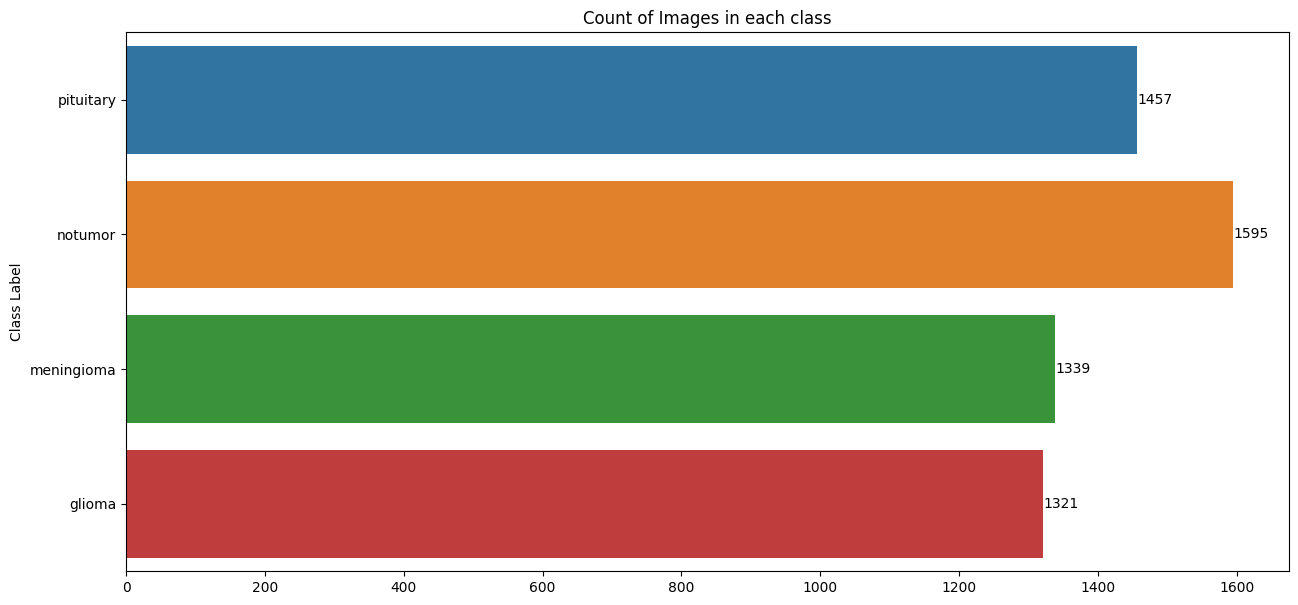

In [10]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data = tr_df, y = tr_df['Class'])

plt.xlabel('')
plt.ylabel('Class Label')
plt.title('Count of Images in each class')
ax.bar_label(ax.containers[0])
plt.show()

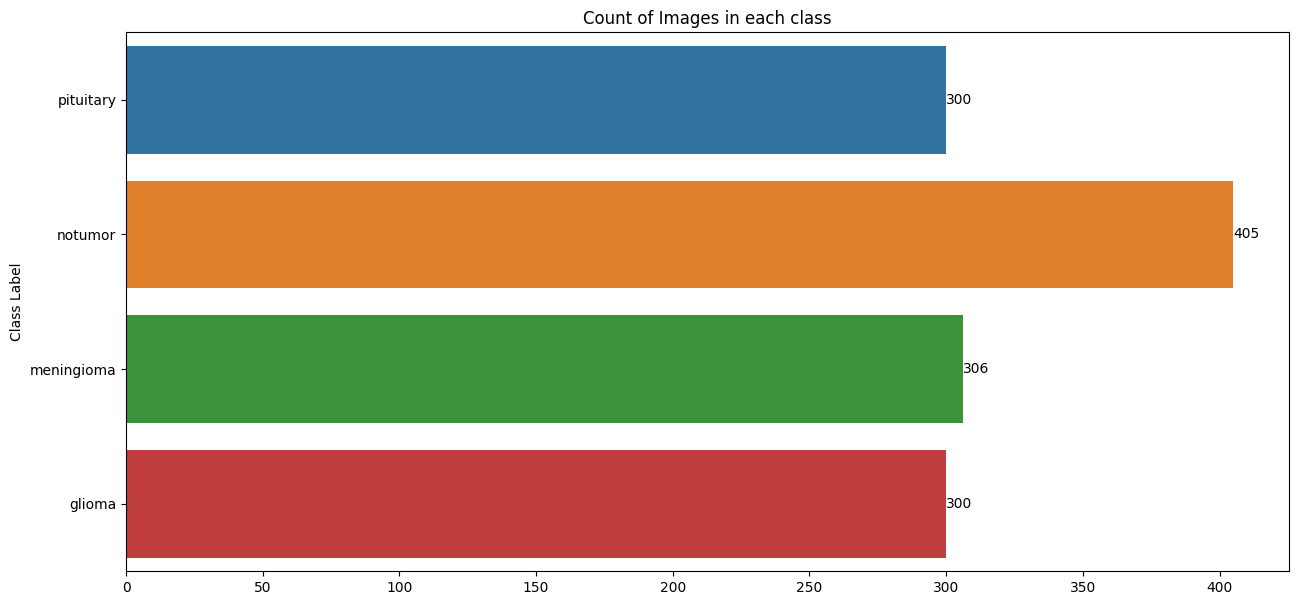

In [11]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data = ts_df, y = ts_df['Class'])

plt.xlabel('')
plt.ylabel('Class Label')
plt.title('Count of Images in each class')
ax.bar_label(ax.containers[0])
plt.show()

## Train Test Valid Split

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [12]:
valid_df.head()

,Class Path,Class
1297,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
723,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
61,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
778,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


## Data Preprocessing

In [14]:
batch_size = 16
img_size = (299, 299)

tr_gen = _gen_1.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen_2.flow_from_dataframe(valid_df, x_col='Class Path',y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = _gen_2.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Getting samples from data

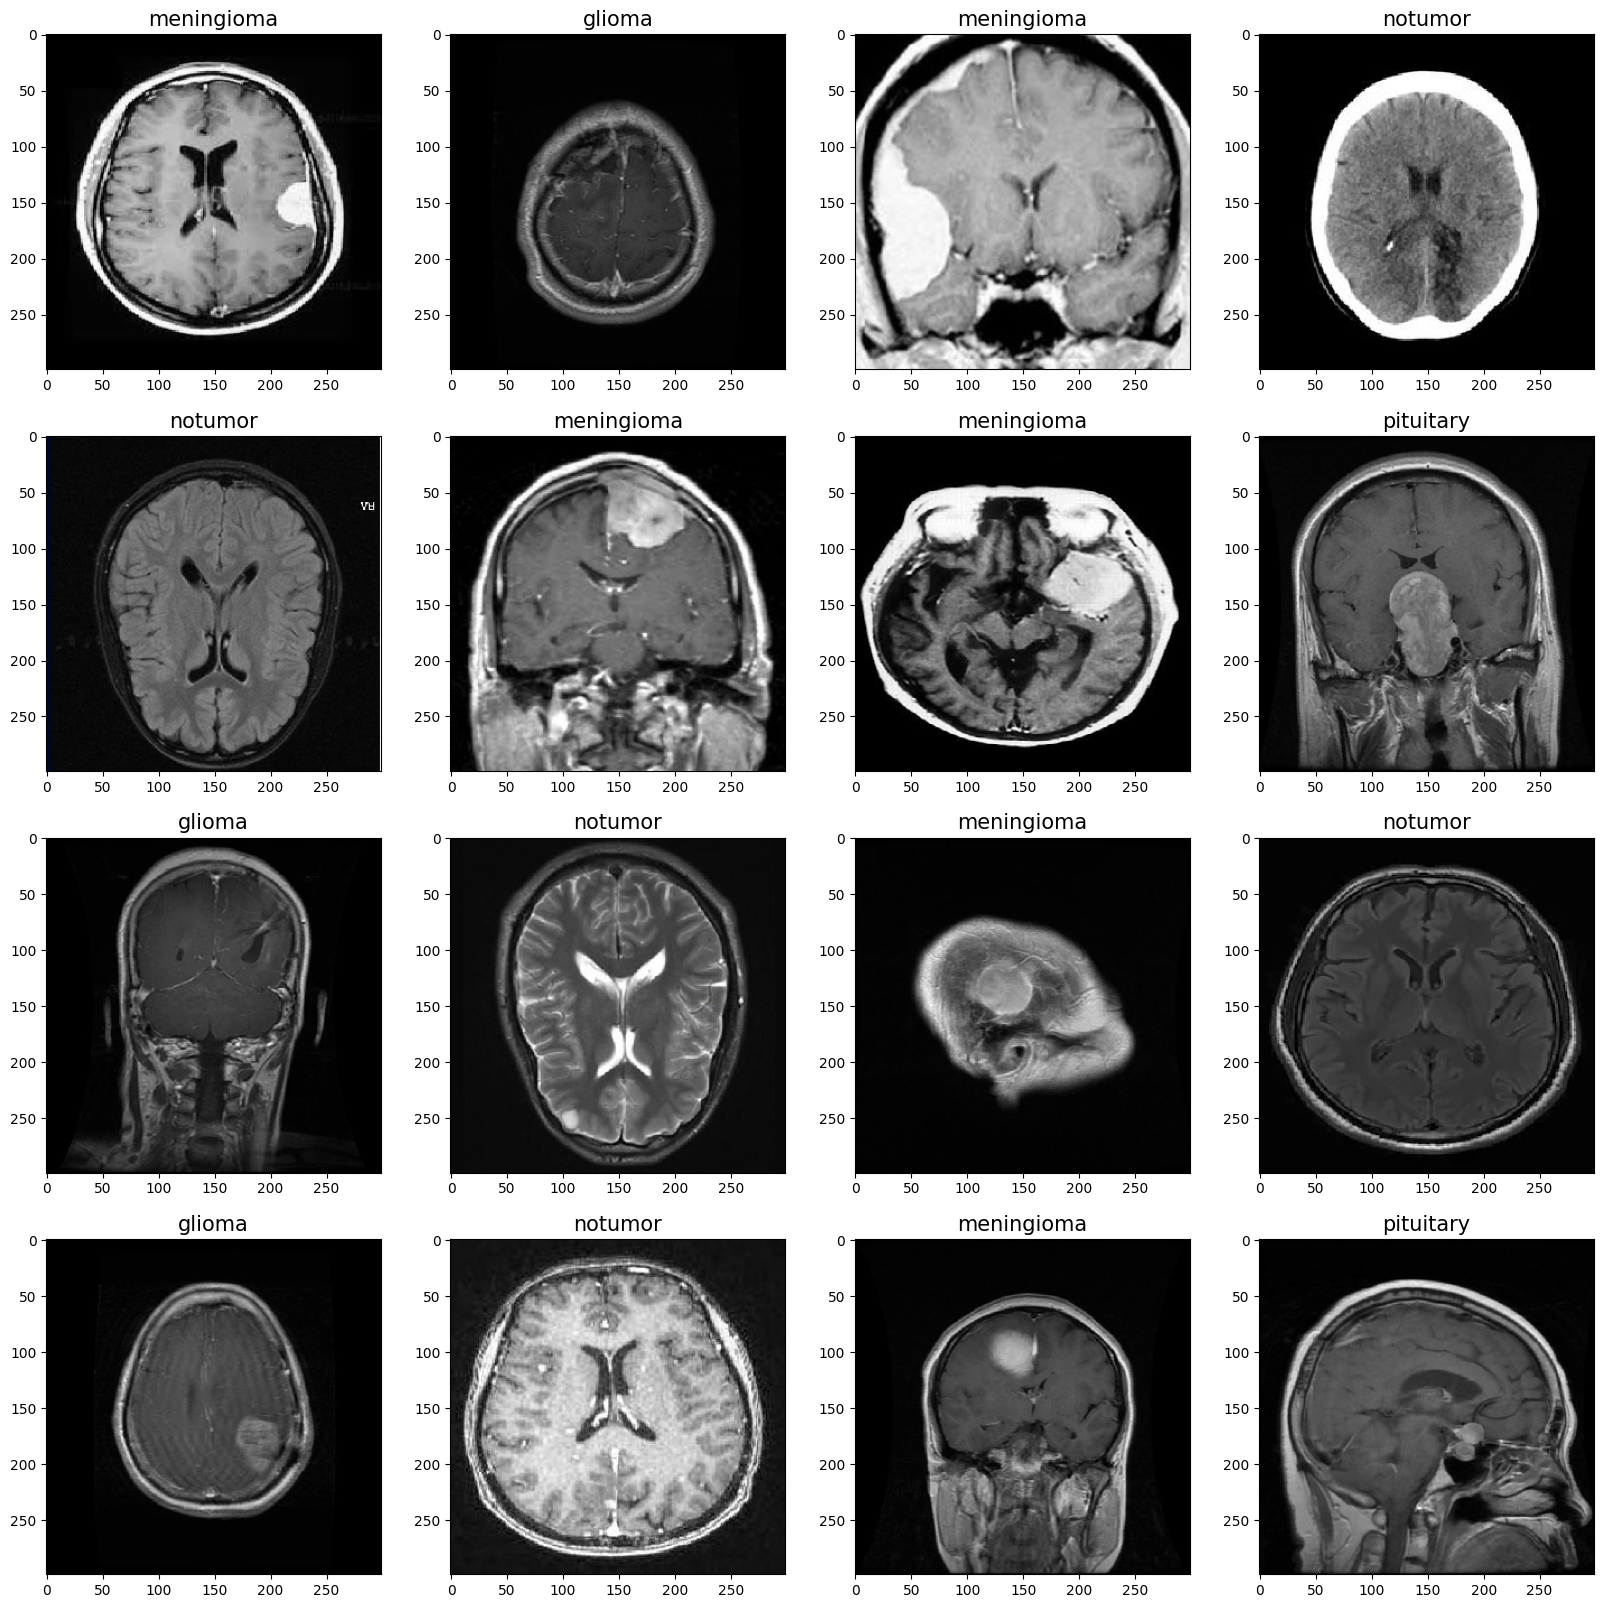

In [19]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

## Training

### Train a model from scratch v1

In [20]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
#     MaxPooling2D(),
#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(4, activation='softmax')
# ])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Deep Learning Model using imagenet as the Base Model 

In [ ]:
img_shape=(299,299,3)

inputs = Input(shape=img_shape)

base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_tensor= inputs, pooling= 'max')

# Custom layers
x = Flatten()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(4, activation='softmax')(x)

# Final model
model = Model(inputs=inputs, outputs=outputs)

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

I0000 00:00:1751552803.229680      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
hist = model.fit(tr_gen, validation_data=(valid_gen), epochs=10, shuffle= False)

Epoch 1/10


I0000 00:00:1751552841.704578      93 service.cc:148] XLA service 0x7a65dc0029b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751552841.705377      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751552844.149971      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751552855.041246      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751552855.251003      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751552856.324866      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751552856.5555

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8202 - loss: 0.5487 - precision: 0.8628 - recall: 0.7522

E0000 00:00:1751552962.223892      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751552962.460511      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751552962.986670      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751552963.247361      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


357/357 ━━━━━━━━━━━━━━━━━━━━ 155s 274ms/step - accuracy: 0.8204 - loss: 0.5480 - precision: 0.8630 - recall: 0.7526 - val_accuracy: 0.9450 - val_loss: 0.1554 - val_precision: 0.9478 - val_recall: 0.9420
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - accuracy: 0.9704 - loss: 0.0909 - precision: 0.9732 - recall: 0.9682 - val_accuracy: 0.9679 - val_loss: 0.1358 - val_precision: 0.9679 - val_recall: 0.9679
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - accuracy: 0.9871 - loss: 0.0398 - precision: 0.9885 - recall: 0.9866 - val_accuracy: 0.9924 - val_loss: 0.0198 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - accuracy: 0.9922 - loss: 0.0287 - precision: 0.9922 - recall: 0.9918 - val_accuracy: 0.9817 - val_loss: 0.0618 - val_precision: 0.9832 - val_recall: 0.9817
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 87s 244ms/step - accuracy: 0.9946 - loss: 0.0159 - precision: 0.9946 - recall: 0.9939 - val_accuracy: 0.9878 - val_los

In [ ]:
version_num = input("Enter the Version Number of your model :")
model.save(f"/kaggle/working/my_cnn_model_{version_num}.h5")

Enter the Version Number of your model : 4


If you have the model load it from following cell to skip the training

In [ ]:
# model = load_model(f"/kaggle/input/cnn_model/tensorflow2/default/1/my_cnn_model_4 (1).h5")

I0000 00:00:1751630950.373735      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
try:
    model = load_model(f"/kaggle/working/my_cnn_model_{version_num}.h5")
except (NameError):
    version_num = input("Enter the Version Number of your model you want to load:")
    model = load_model(f"/kaggle/working/my_cnn_model_{version_num}.h5")

print(f"Model my_cnn_model_{version_num}.h5 load successfully")

I0000 00:00:1751610562.943859      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


NameError: name 'version_num' is not defined

## Evaluate using Model Histograms

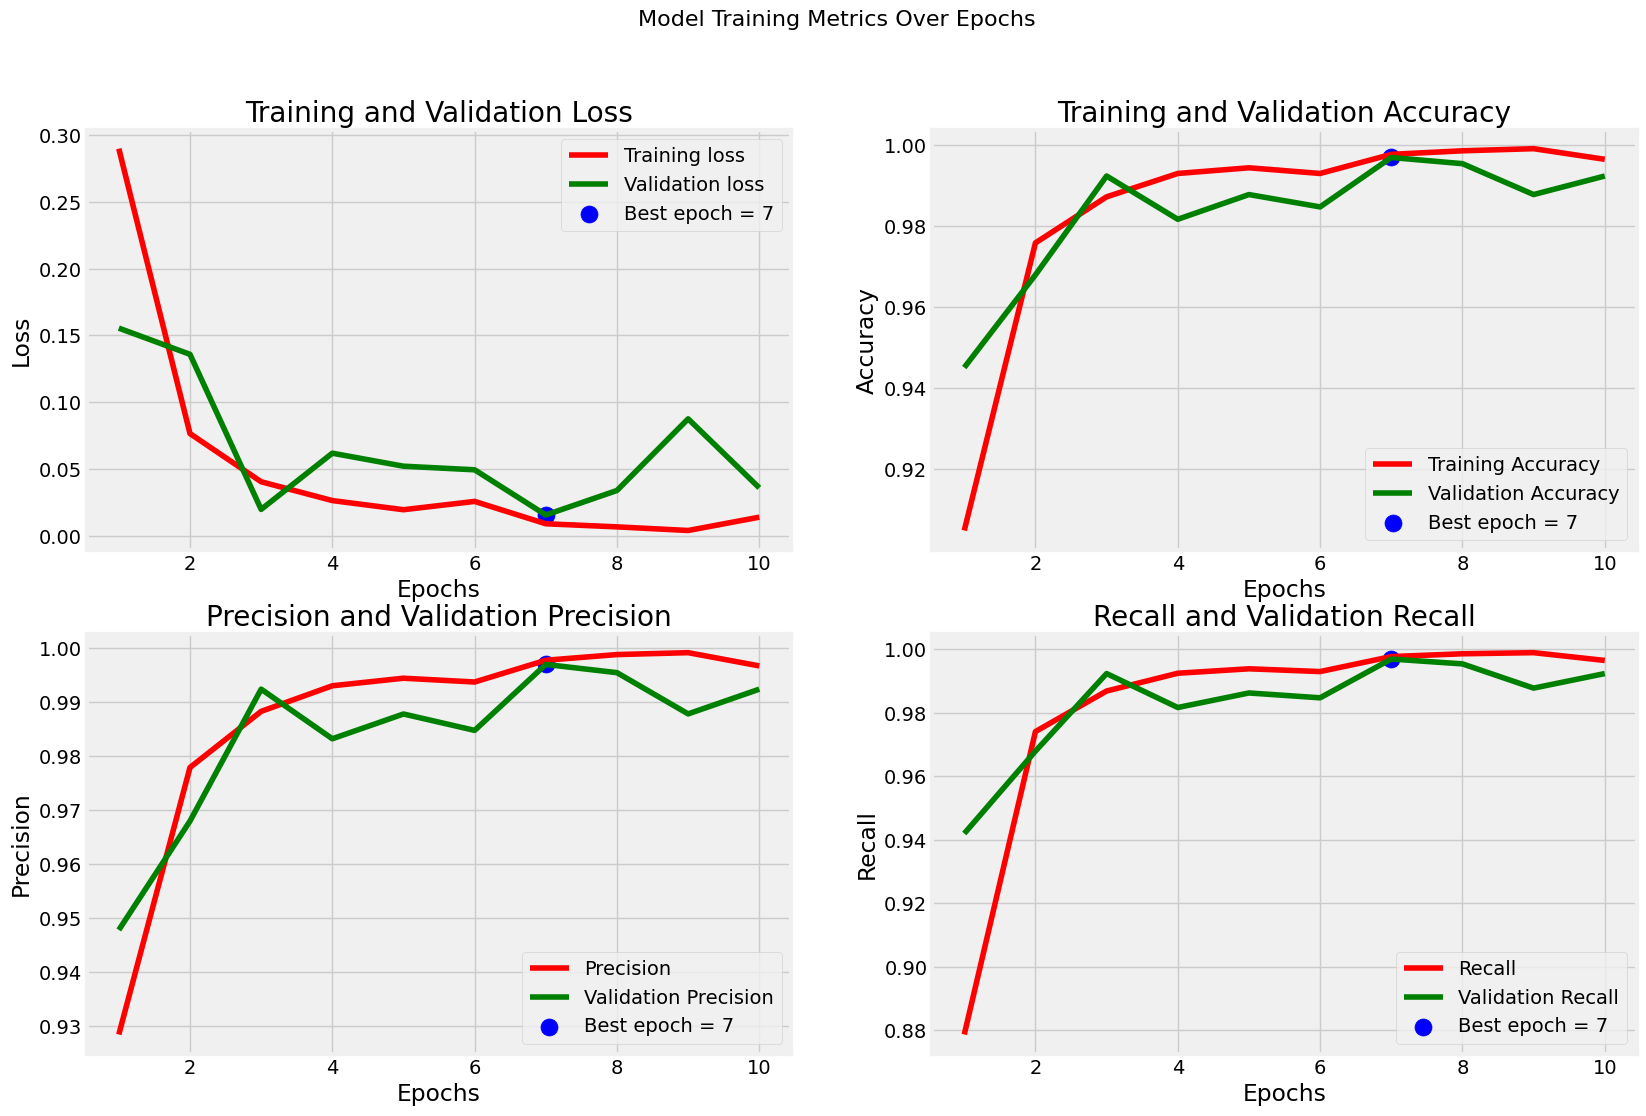

In [30]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

## Test Evaluation

In [31]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.9996 - loss: 0.0013 - precision: 0.9996 - recall: 0.9994
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9892 - loss: 0.0209 - precision: 0.9892 - recall: 0.9892
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9964 - loss: 0.0167 - precision: 0.9982 - recall: 0.9964
Train Loss: 0.0013
Train Accuracy: 99.96%
--------------------
Validation Loss: 0.0359
Validation Accuracy: 99.24%
--------------------
Test Loss: 0.0400
Test Accuracy: 99.24%


I0000 00:00:1751610774.420126      75 service.cc:148] XLA service 0x7cab44001fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751610774.420913      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751610774.885375      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step

I0000 00:00:1751610780.169741      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step


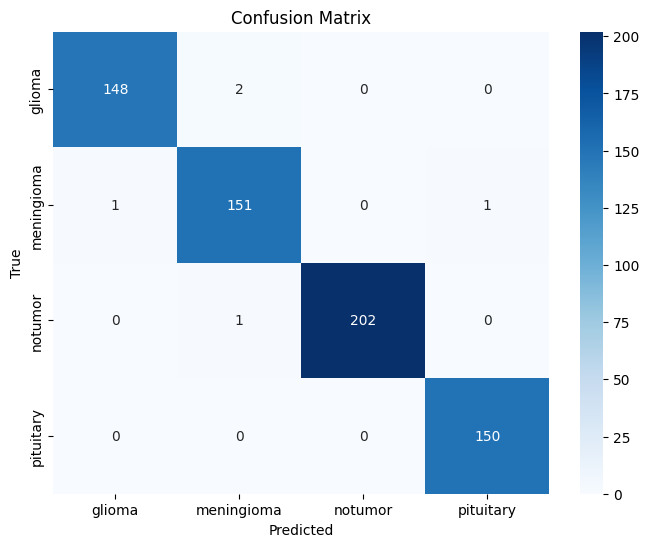

Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       150
  meningioma       0.98      0.99      0.98       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [29]:
evaluate_model(model, ts_gen, classes)

# Explainable AI

In [16]:
%pip install lime
%pip install shap
%pip install innvestigate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 11.9 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.2 MB/s eta 0:00:00
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=78f26d321239da6bfcdf480709944a662c06be3fa11719aa268545a4e56c3650
  Stored in direc

## Imports

In [17]:
from lime import lime_image
import shap
# import innvestigate
# ---------------------------------------------------
from skimage.segmentation import mark_boundaries
from PIL import Image
from skimage import io

In [18]:
def preprocess_input(img_path):
    img = Image.open(img_path).resize((299, 299)).convert('RGB')
    arr = np.array(img) / 255.0          # → [0, 1]
    arr = (arr - 0.5) / 0.5              # → [-1, 1], same as model training
    return arr


def preprocess_image(img_path):
    img = Image.open(img_path).resize((299, 299)).convert('RGB')
    arr = np.array(img) / 255.0          # → [0, 1]
    return arr

def predict_fn(images):
    return model.predict(np.array(images))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

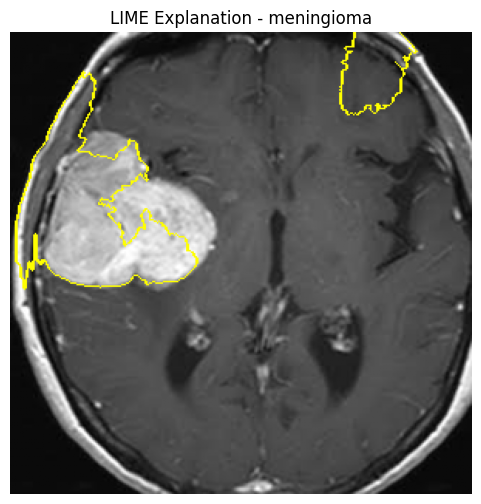

In [ ]:
# LIME for a single image
random_imgs = ["/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0025.jpg"]

img_path = random_imgs[0]
img_arr = preprocess_image(img_path)

# Run LIME
explanation = explainer.explain_instance(
    image=img_arr,
    classifier_fn=predict_fn,
    top_labels=1,
    num_samples=1000,
    hide_color=0
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)

# Show result
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation - {img_path.split('/')[-2]}")
plt.axis('off')
plt.show()

## 1. LIME

In [ ]:
import os
import random
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define test folder path
test_folder = '/kaggle/input/brain-tumor-mri-dataset/Testing'
all_classes = os.listdir(test_folder)
all_classes.remove("notumor")
all_paths = []

# Collect all image paths
for cls in all_classes:
    class_path = os.path.join(test_folder, cls)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.endswith(('.jpg', '.png')):
                all_paths.append(os.path.join(class_path, img_file))

# Pick 8 random images
random_imgs = random.sample(all_paths, 8)
# random_imgs = ["/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0025.jpg"]

# Plotting LIME explanations for each
explainer = lime_image.LimeImageExplainer()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

print(random_imgs)
for i, img_path in enumerate(random_imgs):
    # Load and preprocess image
    img_arr = preprocess_image(img_path)
    print(img_arr.shape)

    # Get explanation
    explanation = explainer.explain_instance(
        image=img_arr,
        classifier_fn=predict_fn,
        top_labels=1,
        num_samples=1000,
        hide_color=0
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False
    )

    overlay = mark_boundaries(temp, mask)
    
    # Plot
    ax = axes[i // 4, i % 4]
    ax.imshow(overlay)
    ax.set_title(f"{img_path.split('/')[-2]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

['/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0230.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0266.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0091.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0105.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0257.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0247.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0212.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0171.jpg']
(299, 299, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

## 2. Counterfactual Explanations

In [24]:
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)

In [46]:
from tqdm import tqdm
import numpy as np

train_embeddings = []
train_paths = []
train_labels = []

notumor_df = tr_df.loc[tr_df['Class']=='notumor']

for i, row in tqdm(notumor_df.iterrows(), total=len(notumor_df)):
    path = row['Class Path']
    label = row['Class']
    img = preprocess_input(path)
    img = np.expand_dims(img, axis=0)
    
    embedding = feature_model.predict(img, verbose=0)
    
    train_embeddings.append(embedding.squeeze())
    train_paths.append(path)
    train_labels.append(label)

train_embeddings = np.array(train_embeddings)

100%|██████████| 1595/1595 [02:02<00:00, 12.99it/s]


In [47]:
np.save('notumor_embeddings.npy', train_embeddings)
pd.DataFrame({'path': train_paths, 'label': train_labels}).to_csv('notumor_paths.csv')

If you have the train_embeddings and notumor_paths.csv files then run the below cell without creating them again

In [ ]:
# train_embeddings = np.load('/kaggle/input/cnn_model/tensorflow2/default/1/notumor_embeddings.npy')
# df = pd.read_csv('/kaggle/input/cnn_model/tensorflow2/default/1/notumor_paths.csv')
# train_paths = df['path'].tolist()
# train_labels = df['label'].tolist()

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

def show_counterfactuals(test_img_path, true_class, top_k=5):
    # Get test embedding
    test_img = preprocess_input(test_img_path)
    test_img = np.expand_dims(test_img, axis=0)
    test_emb = feature_model.predict(test_img, verbose=0)

    # Compute similarity
    sims = cosine_similarity(test_emb, train_embeddings)[0]
    
    # Rank by similarity
    sorted_idx = np.argsort(-sims)
    
    # Filter for counterfactuals (different class)
    cf_paths = []
    for idx in sorted_idx:
        if train_labels[idx] != true_class:
            cf_paths.append(train_paths[idx])
        if len(cf_paths) == top_k:
            break

    # Plot
    fig, axes = plt.subplots(1, top_k + 1, figsize=(3 * (top_k + 1), 3))
    
    axes[0].imshow(Image.open(test_img_path))
    axes[0].set_title("Input")
    axes[0].axis('off')
    
    for i, path in enumerate(cf_paths):
        axes[i + 1].imshow(Image.open(path))
        axes[i + 1].set_title("CF")
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

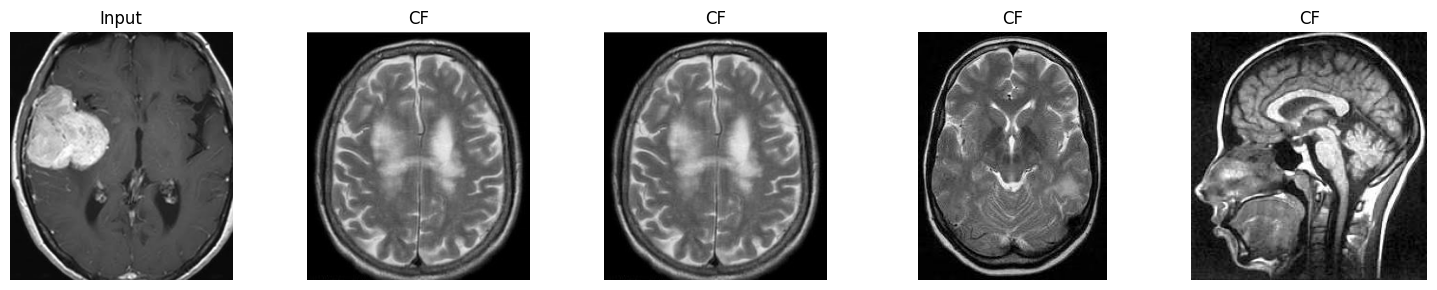

In [32]:
example_img = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0025.jpg'
true_class = 'meningioma'

show_counterfactuals(example_img, true_class, top_k=4)

# Uncertainity Prediction

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import random

# === SETUP ===
img_size = (299, 299)
batch_size = 16
num_classes = 4  # ['glioma', 'meningioma', 'pituitary', 'notumor']
ensemble_size = 5

# === Data Generators with Random Shuffling ===
def get_generators(tr_gen, valid_gen, seed=None):

    tr_gen = tr_gen.flow_from_dataframe(
        dataframe=tr_df,
        x_col='Class Path', y_col='Class',
        target_size=img_size, batch_size=batch_size,
        seed=seed, shuffle=True)

    val_gen = valid_gen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='Class Path', y_col='Class',
        target_size=img_size, batch_size=batch_size,
        seed=seed, shuffle=True)

    return tr_gen, val_gen

# === Model Architecture ===
def create_model():
    inputs = Input(shape=(299, 299, 3))
    base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_tensor= inputs, pooling= 'max')

    x = Flatten()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adamax(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    return model

# === Training Loop ===
for i in range(ensemble_size):
    print(f"\n🔁 Training model {i+1}/{ensemble_size}")
    seed = random.randint(0, 9999)
    train_gen, val_gen = get_generators(seed=seed, tr_gen = _gen_1, valid_gen=_gen_2 )
    
    model = create_model()
    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=5,
                        verbose=1)
    
    model.save(f'ensemble_model_{i+1}.h5')
    print(f"✅ Saved: ensemble_model_{i+1}.h5")


🔁 Training model 1/5
Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


I0000 00:00:1751623019.340173      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


I0000 00:00:1751623055.604989      92 service.cc:148] XLA service 0x7bf4100029a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751623055.605713      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751623058.179235      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751623069.203185      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751623069.413844      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751623070.489106      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751623070.7207

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7861 - loss: 0.6145 - precision: 0.8456 - recall: 0.7039

E0000 00:00:1751623176.582889      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751623176.819987      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751623177.346579      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751623177.607159      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


357/357 ━━━━━━━━━━━━━━━━━━━━ 157s 273ms/step - accuracy: 0.7863 - loss: 0.6137 - precision: 0.8458 - recall: 0.7043 - val_accuracy: 0.9511 - val_loss: 0.1037 - val_precision: 0.9524 - val_recall: 0.9466
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.9760 - loss: 0.0734 - precision: 0.9782 - recall: 0.9739 - val_accuracy: 0.9893 - val_loss: 0.0285 - val_precision: 0.9923 - val_recall: 0.9863
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.9856 - loss: 0.0425 - precision: 0.9868 - recall: 0.9851 - val_accuracy: 0.9832 - val_loss: 0.0544 - val_precision: 0.9832 - val_recall: 0.9832
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - accuracy: 0.9887 - loss: 0.0300 - precision: 0.9892 - recall: 0.9879 - val_accuracy: 0.9954 - val_loss: 0.0139 - val_precision: 0.9954 - val_recall: 0.9954
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 88s 243ms/step - accuracy: 0.9930 - loss: 0.0249 - precision: 0.9937 - recall: 0.9930 - val_accuracy: 0.9771 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: meningioma
Entropy: 0.0012826407
Variance (mean): 8.472462e-09


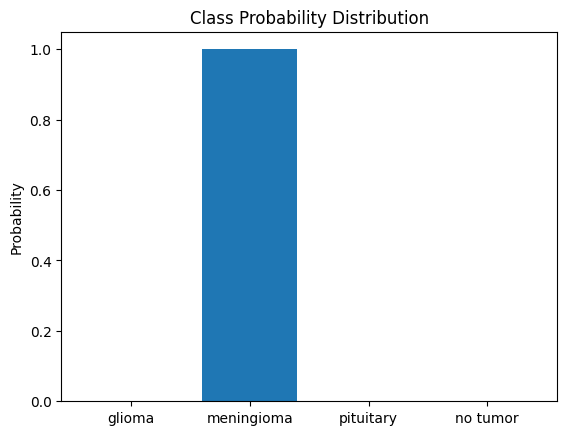

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Load ensemble models
def load_ensemble(models_dir, count=5):
    return [load_model(f"{models_dir}/ensemble_model_{i}.h5") for i in range(1, count + 1)]

# Preprocess image
def preprocess_image(img_path, target_size=(299, 299)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0
    return np.expand_dims(img, axis=0)

# Ensemble uncertainty prediction
def ensemble_predict(models, img_tensor):
    preds = np.array([model.predict(img_tensor)[0] for model in models])  # (n_models, num_classes)
    mean_pred = np.mean(preds, axis=0)
    var_pred = np.var(preds, axis=0)
    pred_entropy = entropy(mean_pred)
    
    return {
        "mean": mean_pred,
        "variance": var_pred,
        "entropy": pred_entropy,
        "class": np.argmax(mean_pred)
    }
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Example usage
models = load_ensemble("path/to/ensemble/models", count=5) # Replace with your models directory
img = preprocess_image("path/to/image.jpg")  # Replace with your image path
result = ensemble_predict(models, img)

# Display results
print("Predicted class:", classes[result["class"]])
print("Entropy:", result["entropy"])
print("Variance (mean):", np.mean(result["variance"]))

# Optional: plot
plt.bar(['glioma', 'meningioma', 'pituitary', 'no tumor'], result["mean"])
plt.title("Class Probability Distribution")
plt.ylabel("Probability")
plt.show()
